### How  do the infected cases evolve for a country (response) as a function of countermeasures (treatment)? 

Data and Descriprion

-----------

- BGS Government Response Tracker. See here (https://www.bsg.ox.ac.uk/news/worlds-first-covid-19-government-response-tracker-launched-today)

- Data contains countermeasures introduced by different countries (with their dates) along with a Stringency Index. Note that Stringency Index is a time varying i.e. countries probably were probably 'less stringent' at the beginning



Hypothesis

------------

Countermeasures introduced by Governments slow the rate of infection. What we would like to uncover is the causal estimate, i.e. what is the rate of new infections as a response to a particular countermeasure?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display
import dowhy.plotter
np.random.seed(42)
%matplotlib inline
import logging
logging.getLogger().setLevel(logging.CRITICAL)
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
df_all = pd.read_excel('OxCGRT_Download_latest_data.xlsx')

In [4]:
# Reform col names by replacing empty spaces with _
df_all.columns = df_all.columns.str.replace(' ', '_')

Methodology

--------------------------

We consider the Confirmed cases for China as it seems to have been only country that has navigated the S-curve (as modelled by SIR dynamics), as seen in the figure below. 



In [5]:
df = df_all[df_all['CountryName']=='China']
x_vals = list(range(len(df)))
df['Delta7'] = df['ConfirmedCases'].values-df['ConfirmedCases'].shift(7).values
df['Delta14'] = df['ConfirmedCases'].values-df['ConfirmedCases'].shift(14).values

#df['Delta7'] = df['Delta7'].diff()
#df['Delta14'] = df['Delta14'].diff()

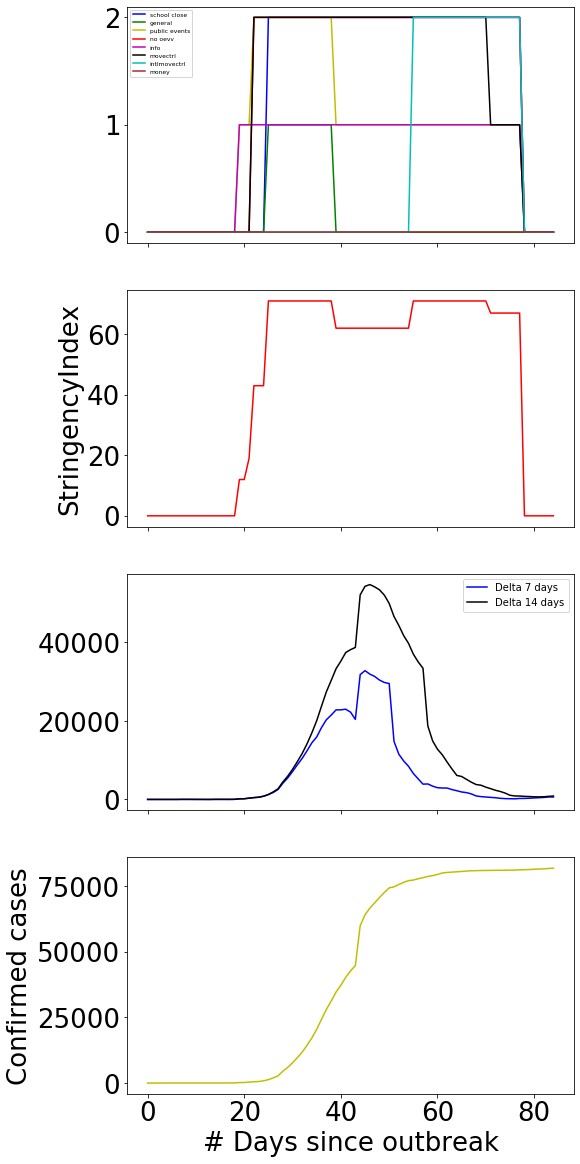

In [6]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(8,20))



df.replace(np.nan,0,inplace=True)
ax[0].plot(x_vals,df['S1_School_closing'],'b')
ax[0].plot(x_vals,df['S2_IsGeneral'],'g')
ax[0].plot(x_vals,df['S3_Cancel_public_events'],'y')
ax[0].plot(x_vals,df['S4_Close_public_transport'],'r')
ax[0].plot(x_vals,df['S5_Public_information_campaigns'],'m')
ax[0].plot(x_vals,df['S6_Restrictions_on_internal_movement'],'k')
ax[0].plot(x_vals,df['S7_International_travel_controls'],'c')
ax[0].plot(x_vals,df['S9_Monetary_measures'],'brown')
#ax[0].plot(df['S10_Emergency investment in health care'],'navy')
ax[0].legend(['school close','general','public events',
                 'no oevv','info','movectrl','intlmovectrl','money','healthcare spend'],prop={'size': 6})

ax[1].plot(x_vals,df['StringencyIndex'],'r')
ax[1].set_ylabel('StringencyIndex')
ax[3].plot(x_vals,df['ConfirmedCases'],'y')
ax[3].set_ylabel('Confirmed cases')
ax[3].set_xlabel('# Days since outbreak')

ax[2].plot(x_vals,df['Delta7'],'b')
ax[2].plot(x_vals,df['Delta14'],'k')
ax[2].legend(['Delta 7 days','Delta 14 days'],prop={'size':10});



A simple causal model is built with the cause effect relationships (as seen in the causal graph). I assume that Stringency Index influences all forms of mobility, travel and closures. It is a beginning, however it is a strong assumption which needs to be validated with Domain Experts.

Note on Delta7: Delta 7 is the difference between current value of Confirmed Cases and the Confirmed Cases 7 days ago. 

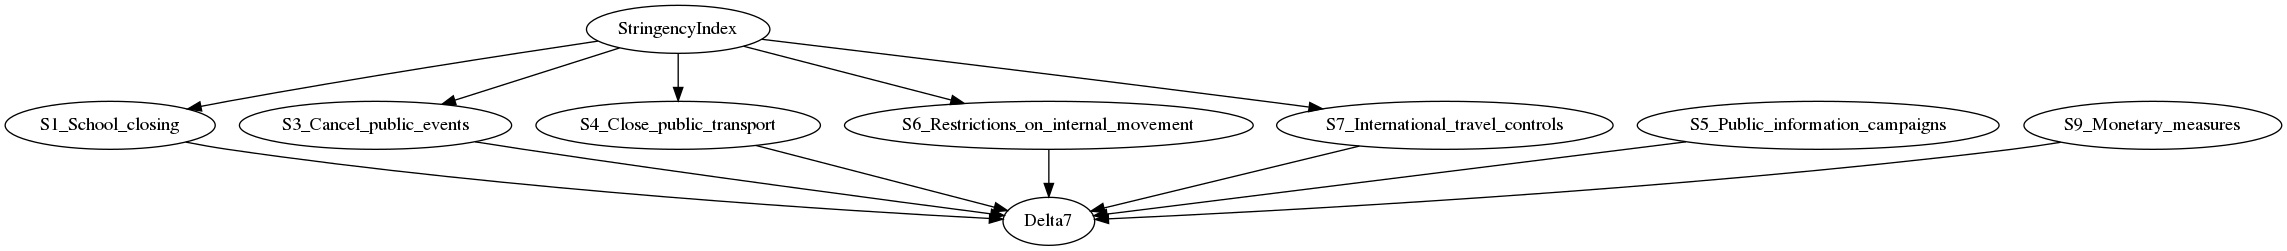

In [7]:
from graphviz import Source
s = Source.from_file('causal_model.dot',format='png')
Image(s.view())

Model and Effects

--------------------------------

With the causal graph modelled above, consider each of the effects and estimate effect using a linear regression with backdoor adjustment along with the p - values

In [8]:
for _treatment in ['S1_School_closing','S3_Cancel_public_events','S4_Close_public_transport','S6_Restrictions_on_internal_movement']:
    model = CausalModel(data=df,treatment=[_treatment],outcome='Delta7',instruments=[],graph='causal_model.dot',proceed_when_unidentifiable=True)
    causal_estimate_reg = model.estimate_effect(model.identify_effect(),method_name='backdoor.linear_regression',
                                                test_significance=True)
    print('%s->%s-->%s'%(_treatment,causal_estimate_reg.value,causal_estimate_reg.significance_test['p_value']))

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['S1_School_closing'] on outcome ['Delta7']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['StringencyIndex', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Delta7~S1_School_closing+StringencyIndex+S1_School_closing*S5_Public_information_campaigns+S1_School_closing*S4_Close_public_transport+S1_School_closing*S6_Restrictions_on_internal_movement+S1_School_closing*S7_International_travel_controls+S1_School_closing*S9_Monetary_measures+S1_School_clo

S1_School_closing->2570.4553186101843-->0.0030000000000000027


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['S4_Close_public_transport'] on outcome ['Delta7']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['StringencyIndex', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Delta7~S4_Close_public_transport+StringencyIndex+S4_Close_public_transport*S5_Public_information_campaigns+S4_Close_public_transport*S6_Restrictions_on_internal_movement+S4_Close_public_transport*S7_International_travel_controls+S4_Close_public_transport*S9_Monetary_measures+S4_Close_

S3_Cancel_public_events->-4842.08603445287-->0.012


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['S6_Restrictions_on_internal_movement'] on outcome ['Delta7']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['StringencyIndex', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Delta7~S6_Restrictions_on_internal_movement+StringencyIndex+S6_Restrictions_on_internal_movement*S5_Public_information_campaigns+S6_Restrictions_on_internal_movement*S4_Close_public_transport+S6_Restrictions_on_internal_movement*S7_International_travel_controls+S6_Restricti

S4_Close_public_transport->5377.805713963064-->0.07099999999999995
S6_Restrictions_on_internal_movement->2276.750342988157-->0.0040000000000000036
